<a href="https://colab.research.google.com/github/demonlexe/cs4375-group17/blob/main/validation_blip.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Testing blip on validation images from dataset

References: https://github.com/huggingface/notebooks/blob/main/examples/image_captioning_blip.ipynb

# Extract URLS from ProcessedData.json

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
import json

# Load the JSON data
with open('/content/drive/MyDrive/Colab-Notebooks/cs4375-final/ProcessedData.json', 'r') as file:
    data = json.load(file)

# Extract image URLs
image_urls = [entry['url'] for entry in data]

# Extract alt tags
alt_tags = [entry['alt_tag'] for entry in data]

# Save the extracted image URLs to a new JSON file
with open('/content/drive/MyDrive/Colab-Notebooks/cs4375-final/image_urls.json', 'w') as outfile:
    json.dump(image_urls, outfile, indent=4)

# Save extracted alt tags to a new JSON file
with open('/content/drive/MyDrive/Colab-Notebooks/cs4375-final/alt_tags.json', 'w') as outfile:
    json.dump(alt_tags, outfile, indent=4)


In [3]:
# Get the count of URLs
url_count = len(image_urls)

print("Number of URLs:", url_count)

Number of URLs: 20926


In [9]:
# Extract the last 5926 entries
validation_image_urls = image_urls[-5926:]
validation_alt_tags = alt_tags[-5926:]

# Save the validation set to new JSON files
with open('/content/drive/MyDrive/Colab-Notebooks/cs4375-final/validation_image_urls.json', 'w') as outfile:
    json.dump(validation_image_urls, outfile, indent=4)

with open('/content/drive/MyDrive/Colab-Notebooks/cs4375-final/validation_alt_tags.json', 'w') as outfile:
    json.dump(validation_alt_tags, outfile, indent=4)

# Peforming Inference

References: https://colab.research.google.com/github/salesforce/BLIP/blob/main/demo.ipynb#scrollTo=cbcb066b

Set runtime to 'T4 GPU'

In [5]:
from transformers import BlipForConditionalGeneration, AutoProcessor

model = BlipForConditionalGeneration.from_pretrained("ybelkada/blip-image-captioning-base-football-finetuned").to('cuda')
processor = AutoProcessor.from_pretrained("ybelkada/blip-image-captioning-base-football-finetuned")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.72k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/431 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/488 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

## Testing BLIP inference on singular image

Print out golden label, generated caption, and image

<Response [200]>
golden label:  A distraught woman talks into a microphone with her eyes closed, surrounded by reporters. On the front of the woman's white T-shirt there is a printed color portrait of a smiling man. Next to her stands a younger woman with her head down.


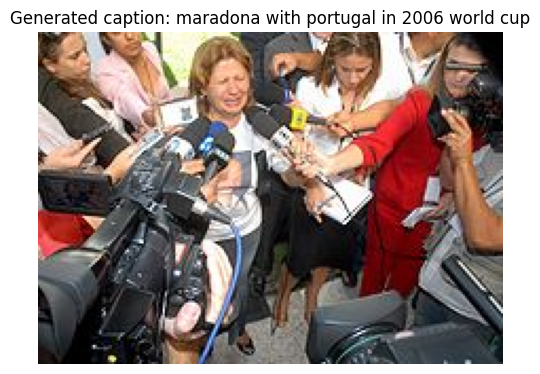

In [11]:
import json
import cv2
import numpy as np
import requests
from PIL import Image
from matplotlib import pyplot as plt

# Load validation image URLs from JSON file
with open('/content/drive/MyDrive/Colab-Notebooks/cs4375-final/validation_image_urls.json', 'r') as file:
    validation_image_urls = json.load(file)

# Choose one URL for inference (e.g., the first one)
url = validation_image_urls[0]

# Define headers for Wikipedia image download
headers = {
    'User-Agent': 'validation-blip.ipynb'
}

# Download the image using requests
response = requests.get(url, headers=headers, stream=True)
print(response)
image_array = np.asarray(bytearray(response.content), dtype="uint8")
image = cv2.imdecode(image_array, cv2.IMREAD_COLOR)

# Convert the image to RGB format
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Convert to PIL format
image_pil = Image.fromarray(image_rgb)

# Prepare the image for the model
inputs = processor(images=image_pil, return_tensors="pt").to('cuda')
pixel_values = inputs.pixel_values

# Generate caption
generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

# Get golden label alt_tag
with open('/content/drive/MyDrive/Colab-Notebooks/cs4375-final/validation_alt_tags.json', 'r') as file:
    validation_alt_tags = json.load(file)
alt_tag = validation_alt_tags[0]

print("golden label: ", alt_tag)

# Display the image and generated caption
plt.figure(figsize=(6, 6))
plt.imshow(image_rgb)
plt.axis("off")
plt.title(f"Generated caption: {generated_caption}")
plt.show()

In [ ]:
if image is None:
    print("Image is empty. Please check the URL or download process.")

Image is empty. Please check the URL or download process.


## Performing BLIP inference on all urls in validation_image_urls and comparing the resulting caption to the corresponding alt_tag in validation_alt_tags

BLEU Score: 0.012884183211863052


In [15]:
import json
import cv2
import numpy as np
import requests
from PIL import Image
from transformers import BlipProcessor, BlipForConditionalGeneration
from nltk.translate.bleu_score import corpus_bleu

# Load validation image URLs from JSON file
with open('/content/drive/MyDrive/Colab-Notebooks/cs4375-final/validation_image_urls.json', 'r') as file:
    validation_image_urls = json.load(file)

# Load golden labels from JSON file
with open('/content/drive/MyDrive/Colab-Notebooks/cs4375-final/validation_alt_tags.json', 'r') as file:
    validation_alt_tags = json.load(file)

# Initialize BLIP processor and model
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base").to('cuda')

# Define headers for Wikipedia image download
headers = {'User-Agent': 'validation-blip.ipynb'}

# Initialize lists to store generated captions and golden labels
generated_captions = []
golden_labels = []

# Iterate through each URL
for url, alt_tag in zip(validation_image_urls, validation_alt_tags):
    # Download the image using requests
    response = requests.get(url, headers=headers, stream=True)

    # Check if the image is empty
    if response.status_code != 200:
        print(f"Image is empty. Please check the URL {url} or download process.")
        continue

    image_array = np.asarray(bytearray(response.content), dtype="uint8")

    # Check if the image array is empty
    if not image_array.any():
        print(f"Image is empty. Please check the URL {url} or download process.")
        continue

    image = cv2.imdecode(image_array, cv2.IMREAD_COLOR)

    if image is None:
      print(f"Image is empty. Please check the URL {url} or download process.")
      continue

    # Convert the image to RGB format
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Convert to PIL format
    image_pil = Image.fromarray(image_rgb)

    # Prepare the image for the model
    inputs = processor(images=image_pil, return_tensors="pt").to('cuda')
    pixel_values = inputs.pixel_values

    # Generate caption
    generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
    generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

    # Append generated caption and golden label
    generated_captions.append(generated_caption)
    golden_labels.append(alt_tag)

# Calculate BLEU score
bleu_score = corpus_bleu([[label.split()] for label in golden_labels], [caption.split() for caption in generated_captions])

print("BLEU Score:", bleu_score)


Image is empty. Please check the URL https://upload.wikimedia.org/wikipedia/commons/thumb/d/db/Nuclear_Power_Plant_2.jpg/220px-Nuclear_Power_Plant_2.jpg or download process.
Image is empty. Please check the URL https://upload.wikimedia.org/wikipedia/commons/thumb/f/fe/The_Hanging_by_Jacques_Callot.jpg/220px-The_Hanging_by_Jacques_Callot.jpg or download process.
Image is empty. Please check the URL https://upload.wikimedia.org/wikipedia/commons/thumb/d/d1/Hesperornis_BW.jpg/100px-Hesperornis_BW.jpg or download process.
Image is empty. Please check the URL https://upload.wikimedia.org/wikipedia/commons/thumb/8/84/Pi_30K.gif/100px-Pi_30K.gif or download process.
Image is empty. Please check the URL https://upload.wikimedia.org/wikipedia/commons/thumb/5/5e/JohnvonNeumann-LosAlamos.gif/170px-JohnvonNeumann-LosAlamos.gif or download process.
Image is empty. Please check the URL https://upload.wikimedia.org/wikipedia/commons/thumb/8/87/Ezra_Pound_2.jpg/220px-Ezra_Pound_2.jpg or download proce